# Instacart Data Challenge

Directions
We'd love for you to analyze the data and share what you find. We know that you don’t know much about how our team currently is run, but that’s okay. This data set includes information on orders, order location, customer ratings, and any issues reported by the customer for a set of orders.

Please analyze the data in the adjacent tab and share with us the following:
- any observations about our business.
- How would you staff the Customer Support Team?

Please compile your analysis into a document or deck to convey your findings. Use the Data Set as necessary to substantiate your claims.

In [891]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import math

In [892]:
xls = pd.ExcelFile('/Users/nzhang/OneDrive/Data/Instacart/Instacart_Data_Analyst_Challenge.xlsx')
raw_df = pd.read_excel(xls, 'Raw Data (disguised)')
raw_df.head()

,order delivery time,order id,customer order rating,type of issue reported,region
0,2014-06-02 04:23:16 UTC,233599337,5,NaN,chi
1,2014-06-02 03:57:50 UTC,233599376,5,NaN,chi
2,2014-06-02 02:52:38 UTC,233599328,5,NaN,chi
3,2014-06-02 02:52:04 UTC,233599070,5,NaN,chi
4,2014-06-02 02:41:43 UTC,233599100,5,NaN,chi


In [893]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14957 entries, 0 to 14956
Data columns (total 5 columns):
order delivery time       14957 non-null object
order id                  14957 non-null int64
customer order rating     14957 non-null int64
type of issue reported    1087 non-null object
region                    14957 non-null object
dtypes: int64(2), object(3)
memory usage: 584.3+ KB


We have 14956 data points of 5 features. Only the feature "type of issue reported" has nulls.

In [894]:
# Make a copy for data exploration and wrangling
df = raw_df.copy()

In [895]:
# Convert string to date and time
df['datetime'] = df['order delivery time'].apply(lambda s: dt.strptime(s[:19], '%Y-%m-%d %H:%M:%S'))

#### Region handling

In [896]:
# Remove floating spaces
df.loc[df['region'] == 'sf ', 'region'] = 'sf'
df.region.unique()

array(['chi', 'nyc', 'sf'], dtype=object)

#### Timezone handling

In [897]:
# Check corresponding timezone for each city
df2.groupby(['region', 'timezone']).size()

region  timezone
chi     UTC         6430
nyc     UTC         1290
sf      UTC         6443
sf      000          794
dtype: int64

The datetimes are all in UTC, we need to convert to their local time to make more sense. Because the dates are between May and June, we do not need to consider daylight saving.

In [898]:
# Set the datetime object to UTC time zone
utc =  pytz.timezone('UTC')
df['datetime'] = df['datetime'].apply(lambda t:utc.localize(t))

# Convert time to local time
cst = pytz.timezone('America/Chicago')
df.loc[df['region']=='chi', 'datetime'] = df.loc[df['region']=='chi', 'datetime'].apply(lambda t: t.astimezone(cst))

est = pytz.timezone('America/New_York')
df.loc[df['region']=='nyc', 'datetime'] = df.loc[df['region']=='nyc', 'datetime'].apply(lambda t: t.astimezone(est))
    
pst = pytz.timezone('America/Los_Angeles')
df.loc[df['region']=='sf', 'datetime'] = df.loc[df['region']=='sf', 'datetime'].apply(lambda t: t.astimezone(pst))

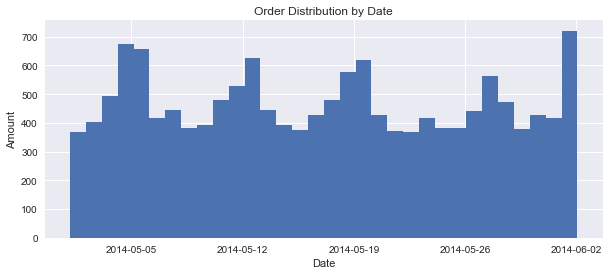

In [899]:
# Plot date range
plt.figure(figsize=(10,4))
df['datetime'].hist(bins=32)
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Order Distribution by Date')
plt.show()

We can identify a weekly circle in the plot above.

#### Weekly Pattern

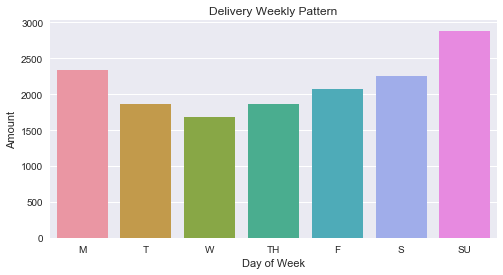

In [900]:
# Extract weekday
df['weekday'] = df['datetime'].apply(lambda d: d.weekday())

# Compute value counts
vc = df['weekday'].value_counts()

# Plot
plt.figure(figsize=(8,4))
sns.barplot(vc.index, vc.values)
plt.xlabel('Day of Week')
plt.ylabel('Amount')
plt.title('Delivery Weekly Pattern')
plt.xticks(np.arange(7), ['M','T','W','TH','F','S','SU'])
plt.show()

There are more customer requests on Monday and weekends. On Wendesday, there are least requests.

#### Daily Pattern

In [901]:
df['15m_interval'] = df['datetime'].apply(lambda d: d.hour*4 + math.floor(d.minute/15))
df['hour'] = df['datetime'].apply(lambda d: d.hour)

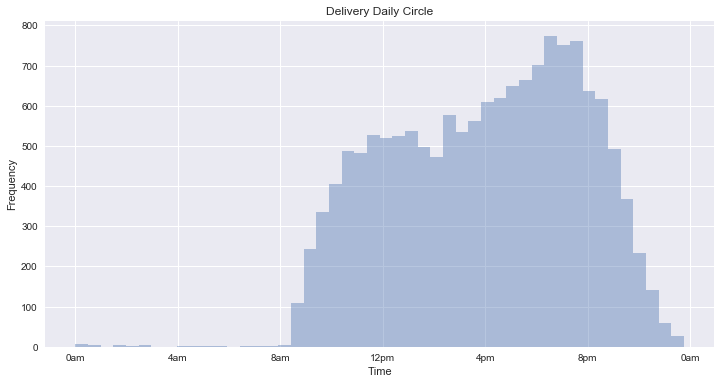

In [902]:
plt.figure(figsize=(12,6))
sns.distplot(df['15m_interval'], hist=True, kde=False, bins=48)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks([0,16,32,48,64,80,96],['0am','4am','8am','12pm','4pm','8pm','0am'])
plt.title('Delivery Daily Circle')
plt.show()

Most orders are placed between 9am and 10pm. There is a peak around 7pm.

#### Location

In [903]:
df['region'].value_counts()

sf     7237
chi    6430
nyc    1290
Name: region, dtype: int64

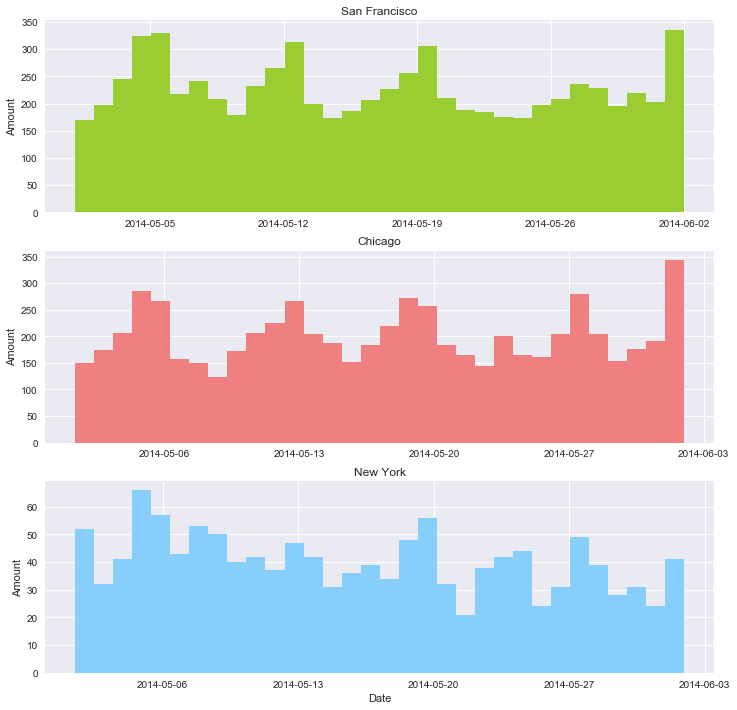

In [904]:
# Create dataframe for each region
df_sf = df[df['region']=='sf']
df_chi = df[df['region']=='chi']
df_nyc = df[df['region']=='nyc']

plt.figure(figsize=(12,12))

plt.subplot(311)
df_sf['datetime'].hist(bins=32, color='yellowgreen')
plt.xlabel('')
plt.ylabel('Amount')
plt.title('San Francisco')

plt.subplot(312)
df_chi['datetime'].hist(bins=32, color='lightcoral')
plt.xlabel('')
plt.ylabel('Amount')
plt.title('Chicago')

plt.subplot(313)
df_nyc['datetime'].hist(bins=32, color='lightskyblue')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('New York')

plt.show()

### Weekday vs Weekend

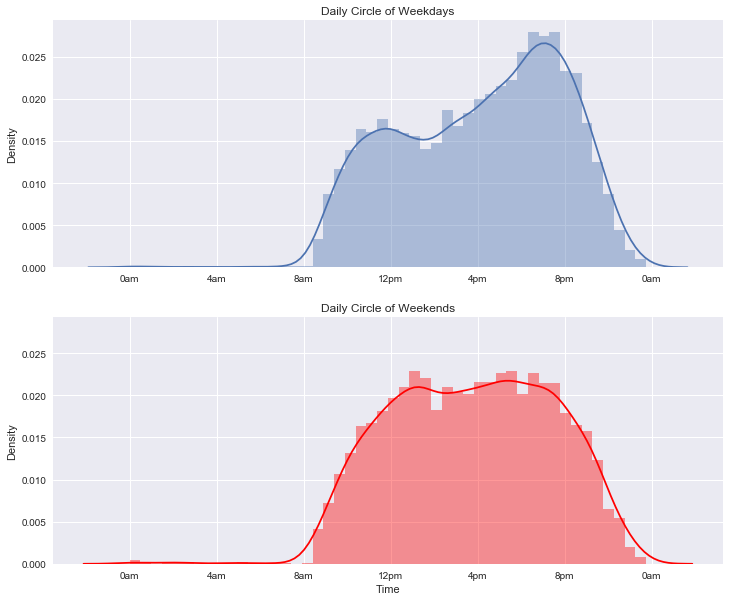

In [905]:
plt.figure(figsize=(12,10))

plt.subplot(211)
ax = sns.distplot(df.loc[df['weekday'].isin([0,1,2,3,4]),'15m_interval'], bins=48, kde=True)
plt.xlabel('')
plt.ylabel('Density')
plt.title('Daily Circle of Weekdays')

plt.subplot(212, sharex=ax, sharey=ax)
sns.distplot(df.loc[df['weekday'].isin([5,6]),'15m_interval'], bins=48, kde=True, color='red')
plt.xlabel('Time')
plt.ylabel('Density')
plt.xticks([0,16,32,48,64,80,96],['0am','4am','8am','12pm','4pm','8pm','0am'])
plt.title('Daily Circle of Weekends')

plt.show()

In [906]:
df.head()

,order delivery time,order id,customer order rating,type of issue reported,region,datetime,weekday,15m_interval,hour
0,2014-06-02 04:23:16 UTC,233599337,5,NaN,chi,2014-06-01 23:23:16-05:00,6,93,23
1,2014-06-02 03:57:50 UTC,233599376,5,NaN,chi,2014-06-01 22:57:50-05:00,6,91,22
2,2014-06-02 02:52:38 UTC,233599328,5,NaN,chi,2014-06-01 21:52:38-05:00,6,87,21
3,2014-06-02 02:52:04 UTC,233599070,5,NaN,chi,2014-06-01 21:52:04-05:00,6,87,21
4,2014-06-02 02:41:43 UTC,233599100,5,NaN,chi,2014-06-01 21:41:43-05:00,6,86,21


#### Rating

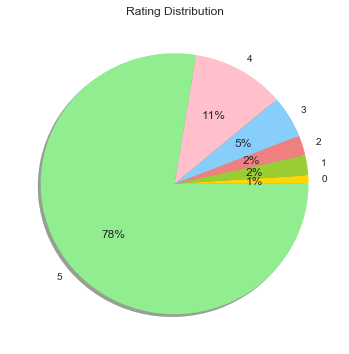

In [907]:
vc = df['customer order rating'].value_counts().sort_index()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen']
# Plot
plt.figure(figsize=(6,6))
plt.pie(vc.values, labels=vc.index, autopct='%1.0f%%', shadow=True, colors=colors)
plt.title('Rating Distribution')
plt.show()

In [908]:
vc = df.groupby(['region'])['customer order rating'].mean()
vc

region
chi    4.711820
nyc    4.431008
sf     4.444383
Name: customer order rating, dtype: float64

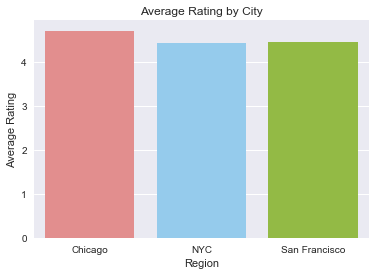

In [909]:
plt.figure(figsize=(6,4))
sns.barplot(vc.index, vc.values, palette=['lightcoral', 'lightskyblue', 'yellowgreen'])
plt.xlabel('Region')
plt.ylabel('Average Rating')
plt.xticks(np.arange(3),['Chicago', 'NYC', 'San Francisco'])
plt.title('Average Rating by City')
plt.show()

In [911]:
hr_rating_sf = df_sf.groupby(['hour'])['customer order rating'].mean()
hr_rating_chi = df_chi.groupby(['hour'])['customer order rating'].mean()
hr_rating_nyc = df_nyc.groupby(['hour'])['customer order rating'].mean()

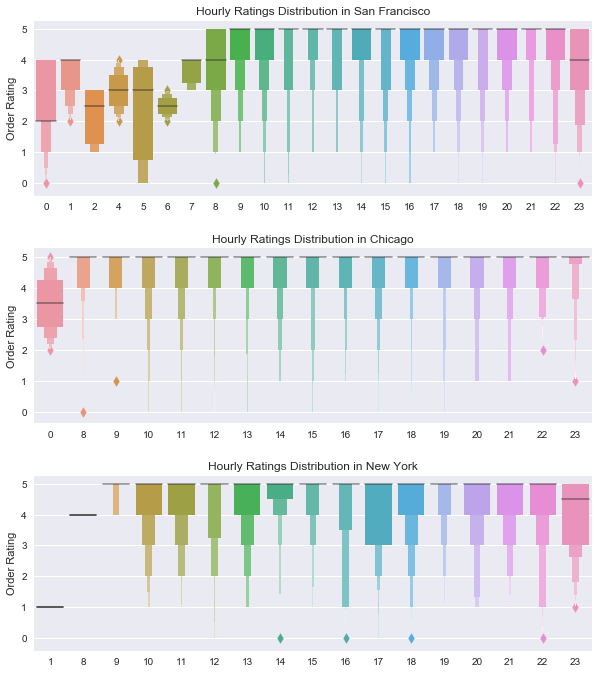

In [912]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=0.3)

plt.subplot(311)
sns.lvplot(x=df_sf['hour'], y=df_sf['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in San Francisco')

plt.subplot(312)
sns.lvplot(x=df_chi['hour'], y=df_chi['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in Chicago')

plt.subplot(313)
sns.lvplot(x=df_nyc['hour'], y=df_nyc['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in New York')


plt.show()

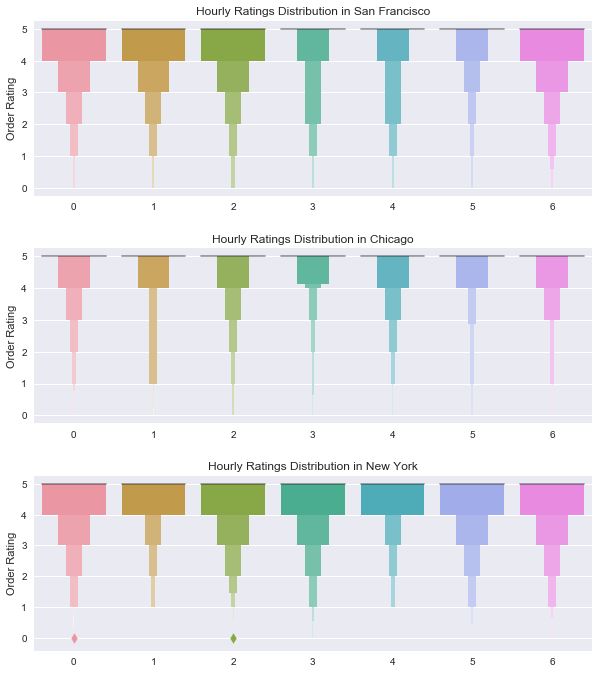

In [913]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=0.3)

plt.subplot(311)
sns.lvplot(x=df_sf['weekday'], y=df_sf['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in San Francisco')

plt.subplot(312)
sns.lvplot(x=df_chi['weekday'], y=df_chi['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in Chicago')

plt.subplot(313)
sns.lvplot(x=df_nyc['weekday'], y=df_nyc['customer order rating'])
plt.xlabel('')
plt.ylabel('Order Rating')
plt.title('Hourly Ratings Distribution in New York')


plt.show()

#### Issue Reported

In [914]:
# Fill nulls
df['type of issue reported'].fillna('Not reported', inplace=True)

In [915]:
# Create a column indicate whether issue reported
df['Issue reported'] = 'No issue'
df.loc[df['type of issue reported'] != 'Not reported', 'Issue reported'] = 'Issue'

In [920]:
# Group ratings into >= 4 and < 4
df['rating group'] = '>= 4'
df.loc[df['customer order rating'] <= 3, 'rating group'] = '< 4'

df_sf = df[df['region']=='sf']
df_chi = df[df['region']=='chi']
df_nyc = df[df['region']=='nyc']

# Create pivot table
pv_sf = pd.pivot_table(df_sf, values='order id', index=['weekday'], columns=['Issue reported'], aggfunc='count')
pv_chi = pd.pivot_table(df_chi, values='order id', index=['weekday'], columns=['Issue reported'], aggfunc='count')
pv_nyc = pd.pivot_table(df_nyc, values='order id', index=['weekday'], columns=['Issue reported'], aggfunc='count')

pv_sf['Percent of Order with issue'] = round(pv_sf['Issue']/(pv_sf['Issue']+pv_sf['No issue'])*100, 2).astype(str) + '%'
pv_chi['Percent of Order with issue'] = round(pv_chi['Issue']/(pv_chi['Issue']+pv_chi['No issue'])*100, 2).astype(str) + '%'
pv_nyc['Percent of Order with issue'] = round(pv_nyc['Issue']/(pv_nyc['Issue']+pv_nyc['No issue'])*100, 2).astype(str) + '%'

In [921]:
print(pv_sf)
print(pv_chi)
print(pv_nyc)

Issue reported  Issue  No issue Percent of Order with issue
weekday                                                    
0                  91      1062                       7.89%
1                  65       801                       7.51%
2                 103       730                      12.36%
3                  86       860                       9.09%
4                  91       888                        9.3%
5                  81       997                       7.51%
6                 176      1206                      12.74%
Issue reported  Issue  No issue Percent of Order with issue
weekday                                                    
0                  45       950                       4.52%
1                  38       787                       4.61%
2                  34       671                       4.82%
3                  23       699                       3.19%
4                  42       863                       4.64%
5                  31       958         

In [922]:
df.groupby(['type of issue reported', 'rating group']).size()

type of issue reported    rating group
Damaged or spoiled        < 4               206
                          >= 4              104
Item charged incorrectly  < 4                 2
                          >= 4               19
Item missing              < 4               113
                          >= 4               65
Not reported              < 4               980
                          >= 4            12890
Other Order Issue         < 4                12
                          >= 4                9
Poor replacement          < 4                44
                          >= 4               10
Poor service              < 4                95
                          >= 4               34
Wrong item                < 4               223
                          >= 4              151
dtype: int64

In [923]:
pv = pd.pivot_table(df, values='order id', index=['type of issue reported'], columns=['rating group'], aggfunc='count')
round(pv.T/pv.sum(axis=1)*100, 1).T

rating group,< 4,>= 4
type of issue reported,,
Damaged or spoiled,66.5,33.5
Item charged incorrectly,9.5,90.5
Item missing,63.5,36.5
Not reported,7.1,92.9
Other Order Issue,57.1,42.9
Poor replacement,81.5,18.5
Poor service,73.6,26.4
Wrong item,59.6,40.4


In [924]:
df['type of issue reported'].value_counts()

Not reported                13870
Wrong item                    374
Damaged or spoiled            310
Item missing                  178
Poor service                  129
Poor replacement               54
Other Order Issue              21
Item charged incorrectly       21
Name: type of issue reported, dtype: int64

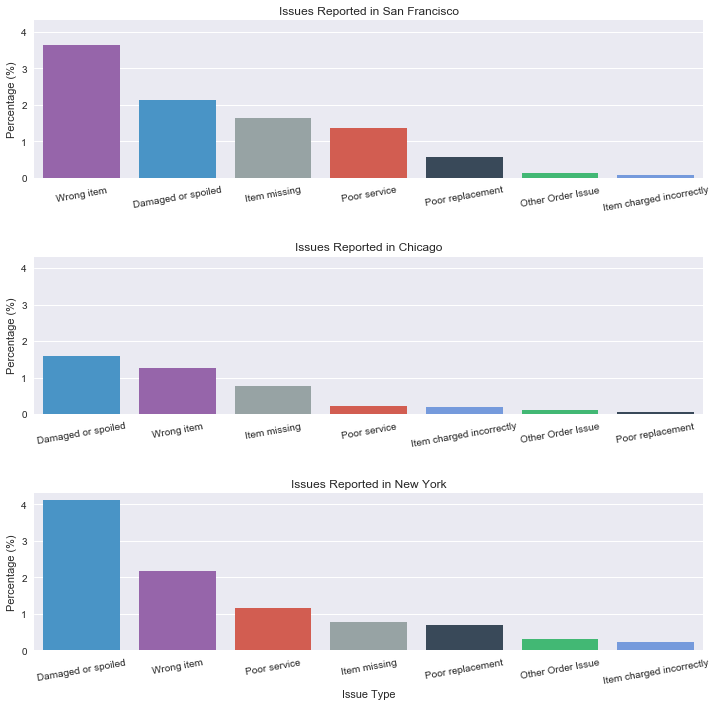

In [933]:
df_issue = df[df['type of issue reported']!='Not reported']
vc_sf = df_issue.loc[df_issue['region']=='sf', 'type of issue reported'].value_counts()
pc_sf = vc_sf / df_sf.shape[0] * 100
vc_chi = df_issue.loc[df_issue['region']=='chi', 'type of issue reported'].value_counts()
pc_chi = vc_chi / df_chi.shape[0] * 100
vc_nyc = df_issue.loc[df_issue['region']=='nyc', 'type of issue reported'].value_counts()
pc_nyc = vc_nyc / df_nyc.shape[0] * 100

# Plot
plt.figure(figsize=(12,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=0.5)

plt.subplot(311)
colors=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#6495ED"]
ax = sns.barplot(pc_sf.index, pc_sf.values, palette=colors)
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.title('Issues Reported in San Francisco')
plt.xticks(rotation=10)

plt.subplot(312, sharey=ax)
colors=["#3498db", "#9b59b6","#95a5a6", "#e74c3c", "#6495ED", "#2ecc71", "#34495e"]
sns.barplot(pc_chi.index, pc_chi.values, palette=colors)
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.title('Issues Reported in Chicago')
plt.xticks(rotation=10)

plt.subplot(313, sharey=ax)
colors=["#3498db", "#9b59b6","#e74c3c", "#95a5a6", "#34495e", "#2ecc71", "#6495ED"]
sns.barplot(pc_nyc.index, pc_nyc.values, palette=colors)
plt.xlabel('Issue Type')
plt.ylabel('Percentage (%)')
plt.title('Issues Reported in New York')
plt.xticks(rotation=10)

plt.show()